# BICYCLE DATA QUALITY

## (01b) Load & process reference data

**Overview:**

This notebook:
- Loads the polygon defining the study area and then creates a grid overlay for the study area.
- Loads the reference data.
- Processes the reference data to create the network structure and atttributes needed in the analysis.

Output files of this notebook are saved to the `../data/REF/'study_area'/processed/` subfolder and used in the notebooks 02 and 03.

***

**Sections:**

1. Load data for study area & define grid used for computation of local results.

2. Load and process reference data.

_____

### 1. Load data for study area & define grid

This step:

- Loads settings for the analysis from the configuration file.
- Reads data for the study area.
- Creates a grid overlay of the study area, with grid cell size as defined in configuration file `config.yml`.

In [1]:
import json
import pickle
from datetime import datetime

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import warnings

from src import evaluation_functions as eval_func
from src import graph_functions as graph_func
from src import simplification_functions as simp_func

%run ../settings/plotdict.py
%run ../settings/yaml_variables.py
%run ../settings/paths.py

warnings.filterwarnings('ignore')

#### Read in data for study area

The size of the study area is 181.38 square kilometers


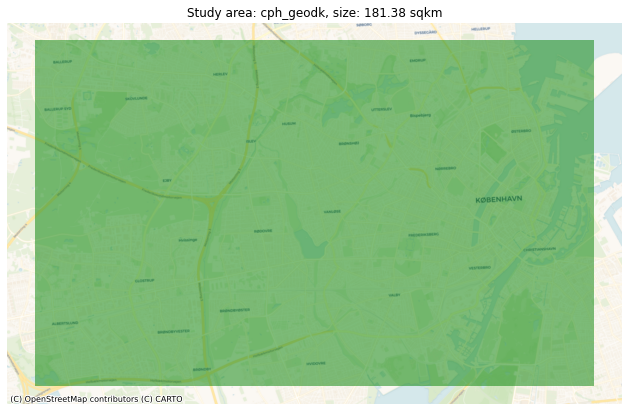

In [2]:
# Read polygon for study area
study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print("Please assign a crs to the study area polygon!")

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f"The size of the study area is {area / 1000000:.2f} square kilometers")

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

study_area_poly.plot(ax=ax, color=pdict["base"], alpha=pdict["alpha_back"])

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)

ax.set_title(f"Study area: {study_area}, size: {area / 1000000:.2f} sqkm")

fig.savefig(ref_resplot_fp + "gpd_area_size_REF.png", dpi=pdict["dpi"])

#### Create grid to be used in the analysis

<div class="alert alert-block alert-info">
<b>User configurations</b>
<br>
<br>
The grid is used to compute local results for many of the quality metrics. The cell size of the grid cells must be specified in the configuration file. Smaller grid cells will increase the computation time but give a more granular result. The grid cell size should not be smaller than the scale at which you would expect actual differences in data quality.
</div>

The grid contains 770 square cells with a side length of 500m and an area of 0.25 square kilometers.


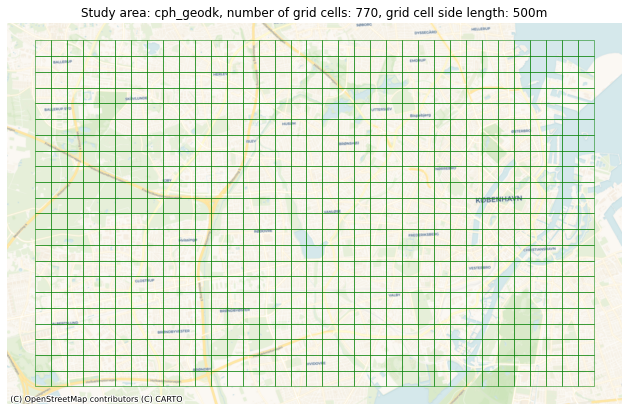

In [3]:
grid = eval_func.create_grid_geometry(study_area_poly, grid_cell_size)

grid["grid_id"] = grid.index

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

grid_cell_area = (grid_cell_size / 1000) ** 2  # in km2
print(
    f"The grid contains {len(grid)} square cells with a side length of {grid_cell_size}m and an area of {grid_cell_area:.2f} square kilometers."
)

grid.plot(ax=ax, facecolor="none", edgecolor=pdict["base"], alpha=pdict["alpha_back"])

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)

ax.set_title(
    f"Study area: {study_area}, number of grid cells: {len(grid)}, grid cell side length: {grid_cell_size}m"
)

fig.savefig(ref_resplot_fp + "gpd_area_grid_REF.png", dpi=pdict["dpi"])

### 2. Load reference data

This step:

- Creates a network from the reference data.
- Projects it to the chosen CRS.
- Clips the data to the polygon defining the study area.
- Measures the infrastructure length of the edges based on the geometry type and whether they allow for bidirectional travel or not.
- Simplifies the network.
- Creates copies of all edge and node datasets indexed by their intersecting grid cell.

In [8]:
# Read reference data
org_ref_data = gpd.read_file(reference_fp)

# Create data with LineStrings only defined by end and start coordinate
ref_data = graph_func.unzip_linestrings(org_ref_data, reference_id_col)

# Create column with id called 'osmid'
ref_data["osmid"] = ref_data["new_edge_id"]
ref_data.drop(["new_edge_id"], axis=1, inplace=True)

# Reproject
if ref_data.crs == None:
    print("Please assign a crs to the study area polygon!")

if ref_data.crs != study_crs:
    ref_data = ref_data.to_crs(study_crs)

assert ref_data.crs == study_crs

# Clip reference data to study area poly
ref_data = ref_data.clip(study_area_poly)

# Convert to osmnx graph object
graph_ref = graph_func.create_osmnx_graph(ref_data)

ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)

# Overview of data
graph_area = eval_func.get_graph_area(ref_nodes, study_area_poly, study_crs)
print(
    f"The reference data covers an area of {graph_area / 1000000:.2f} square kilometers"
)

# Classify edges as protected or unprotected
ref_edges = eval_func.define_protected_unprotected(ref_edges, ref_bicycle_infrastructure_type)
for key, value in ref_edges.protected.value_counts().items():
    print(f"Number of edges where the protection level is '{key}': {value}")

# Summarize attribute values - if there are columns with values for each row instead of a global setting
if bicycle_bidirectional in ref_edges.columns:
    for key, value in ref_edges.bicycle_bidirectional.value_counts().items():
        print(f"Number of edges where 'bicycle_bidirectional' is {key}: {value}")

if reference_geometries in ref_edges.columns:
    for key, value in ref_edges.bicycle_geometries.value_counts().items():
        print(f"Number of edges where the geometry type is '{key}': {value}")

# Add attributes to graph
protected_dict = ref_edges["protected"].to_dict()
nx.set_edge_attributes(graph_ref, protected_dict, "protected")

# Add 'multiple edge' attribute to each edge of the graph
for e in graph_ref.edges:
    graph_ref.edges[e]["multiedge"] = 0

# Count multiple edges and store info at key 0
# (simplification routine keeps only key 0)
for u, v, k in graph_ref.edges:
    if k > 0:
        graph_ref.edges[u, v, 0]["multiedge"] += 1

# Remove geometry attribute (required by simplification function)
for n1, n2, d in graph_ref.edges(data=True):
    d.pop("geometry", None)

# Simplify - the graph is simplified as much as possible, but without combining edges with conflicting values of bicycle infrastructure types
graph_ref_simplified = simp_func.simplify_graph(
    graph_ref, attributes=["protected"], remove_rings=False
)

graph_ref = ox.get_undirected(graph_ref)
ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)
graph_ref_simplified = ox.get_undirected(graph_ref_simplified)

ref_nodes_simplified, ref_edges_simplified = ox.graph_to_gdfs(graph_ref_simplified)

ref_edges["length"] = ref_edges.geometry.length
ref_edges_simplified["length"] = ref_edges_simplified.geometry.length

# Measure the length of bicycle infrastructure (!=from length of edges)
if (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

else:
    print(
        f"Invalid data types for the variables reference_geometetries and/or bicycle_bidirectional!"
    )

print(
    f"The length of the reference network is {ref_edges_simplified.infrastructure_length.sum()/1000 :.2f} kilometers"
)


# Creating coulumns with unique feature id (required by some functions)
ref_edges["edge_id"] = ref_edges.reset_index().index
ref_edges_simplified["edge_id"] = ref_edges_simplified.reset_index().index

ref_id_dict = ref_edges["edge_id"].to_dict()
nx.set_edge_attributes(graph_ref, ref_id_dict, "edge_id")

ref_id_dict_s = ref_edges_simplified["edge_id"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_id_dict_s, "edge_id")

# Saving data to graphs
ref_l_dict = ref_edges["length"].to_dict()
nx.set_edge_attributes(graph_ref, ref_l_dict, "length")

ref_l_dict_s = ref_edges_simplified["length"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_l_dict_s, "length")

ref_il_dict = ref_edges_simplified["infrastructure_length"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_il_dict, "infrastructure_length")

The reference data covers an area of 169.76 square kilometers
Number of edges where the protection level is 'protected': 46097.
Number of edges where the protection level is 'unprotected': 7483.
The length of the reference network is 626.48 kilometers


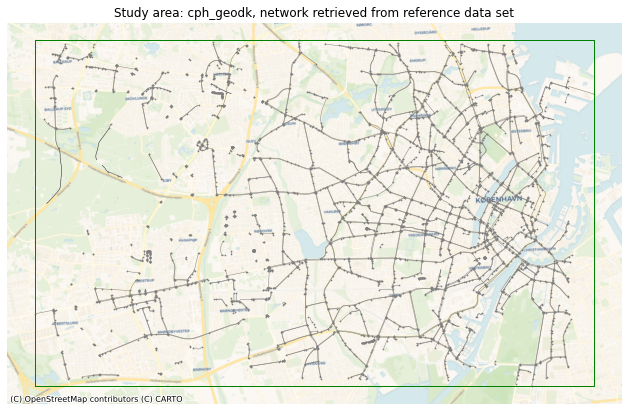

In [5]:
# Plot network
fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

ref_edges_simplified.plot(ax=ax, color=pdict["ref_base"], linewidth=0.5)
ref_nodes_simplified.plot(ax=ax, color=pdict["ref_base"], markersize=0.5)

study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor="None", linewidth=1)

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_2)

ax.set_title(f"Study area: {study_area}, network retrieved from reference data set")

fig.savefig(ref_resplot_fp + "gpd_area_network_REF.png", dpi=pdict["dpi"])

In [6]:
# Join to grid

ref_edges_simp_joined = gpd.overlay(
    ref_edges_simplified.reset_index(), grid, how="intersection", keep_geom_type=True
)
ref_edges_joined = gpd.overlay(
    ref_edges.reset_index(), grid, how="intersection", keep_geom_type=True
)

ref_nodes_simp_joined = gpd.overlay(
    ref_nodes_simplified.reset_index(), grid, how="intersection", keep_geom_type=True
)
ref_nodes_joined = gpd.overlay(
    ref_nodes.reset_index(), grid, how="intersection", keep_geom_type=True
)

# Count features in each grid cell
all_data_ref = [
    ref_edges_joined,
    ref_nodes_joined,
    ref_edges_simp_joined,
    ref_nodes_simp_joined,
]
labels_ref = ["ref_edges", "ref_nodes", "ref_simplified_edges", "ref_simplified_nodes"]

for data, label in zip(all_data_ref, labels_ref):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")


# Recomputing infrastructure length for data joined to grid
ref_edges_simp_joined["length"] = ref_edges_simp_joined["geometry"].length

if (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=x.bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x.reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

else:
    print(
        f"Invalid data types for the variables reference_geometetries and/or bicycle_bidirectional!"
    )

assert round(ref_edges_simplified.infrastructure_length.sum() / 1000, 1) == round(
    ref_edges_simp_joined.infrastructure_length.sum() / 1000, 1
)

In [7]:
# Save reference data

assert len(ref_nodes) == len(ref_nodes.nodeID.unique())
assert len(ref_edges) == len(ref_edges.edge_id.unique())
assert len(ref_edges_simplified) == len(ref_edges_simplified.edge_id.unique())
assert len(ref_nodes_simplified) == len(ref_nodes_simplified.nodeID.unique())

assert "infrastructure_length" in ref_edges_simplified.columns
assert "length" in ref_edges.columns

with open(ref_nodes_fp, "wb") as f:
    pickle.dump(ref_nodes, f)

with open(ref_edges_fp, "wb") as f:
    pickle.dump(ref_edges, f)

with open(ref_nodes_simplified_fp, "wb") as f:
    pickle.dump(ref_nodes_simplified, f)

with open(ref_edges_simplified_fp, "wb") as f:
    pickle.dump(ref_edges_simplified, f)

# Joined data
with open(ref_nodes_joined_fp, "wb") as f:
    pickle.dump(ref_nodes_joined, f)

with open(ref_edges_joined_fp, "wb") as f:
    pickle.dump(ref_edges_joined, f)

with open(ref_nodes_simplified_joined_fp, "wb") as f:
    pickle.dump(ref_nodes_simp_joined, f)

with open(ref_edges_simplified_joined_fp, "wb") as f:
    pickle.dump(ref_edges_simp_joined, f)

print("Reference nodes and edges saved successfully!")

ox.save_graphml(graph_ref, ref_graph_fp)
ox.save_graphml(graph_ref_simplified, ref_graph_simplified_fp)

print("Reference networks saved successfully!")

Reference nodes and edges saved successfully!
Reference networks saved successfully!


In [8]:
# Export grid
grid.to_file(ref_grid_fp)
print("Reference grid saved successfully!")

Reference grid saved successfully!
